@Editors: Tung Nguyen, Mo Nguyen, Jian Yu

@base: 16/01/20 discussion

Main changes: 

- the input is the rating matrix
- Some codes are removed from [v1.0](https://colab.research.google.com/drive/1lRLKVMB90o7nPCNosRnFPBNF7rs8txQA#scrollTo=wuBt2WWN5Zrf) 

#[New Model](https://drive.google.com/file/d/1kN5loA18WyF1-I7BskOw6c9P1bdArxk7/view?usp=sharing): 

![Click](https://drive.google.com/file/d/1kN5loA18WyF1-I7BskOw6c9P1bdArxk7/view?usp=sharing)


#Model implementation framework

TF2.0 and Keras implementation

- Create GMF model
    - Create helper methods: User/item latent
    - Create loss functions
    - Handle input $u_i, v_j$
    - Handle output $\hat{r}_{ij}$

## Organise imports


In [1]:
#@title
#import
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
dt_dir_name= "C:/Users/thinguyen/Desktop/PhD_2020/Python Code/GNN/Mo/sample_data/ml-1m"

In [7]:
#dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])

dataset = pd.read_csv(dt_dir_name +'/'+ 'implicit_rating.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ml1m_ns.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])




In [8]:
#reindex from 0 ids
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
#createMFModel(dataset=dataset)

##Create train test set


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

#Create deep embedding using MLP of the [model](https://drive.google.com/file/d/1kN5loA18WyF1-I7BskOw6c9P1bdArxk7/view?usp=sharing)

##Approach 2: (Ignore this!)

In [10]:
uids = np.sort(dataset.user_id.unique())
iids = np.sort(dataset.item_id.unique())

n_users = len(uids)
n_items = len(iids)

In [11]:
n_users, n_items

(6040, 3706)

In [8]:
#filling the values for adjacency matrices
# uam = np.zeros(shape=(n_users, n_users), dtype=int)
# iam = np.zeros(shape=(n_items, n_items), dtype=int)

# for i in iids:
#   unb = dataset.loc[dataset['item_id'] == i]['user_id'].to_numpy().reshape(-1,)
#   for u1 in unb:
#     for u2 in unb:
#       uam[u1, u2] += 1

In [9]:
# print("orignal rating matrix: ", uam.shape[0]*iam.shape[0])
# print("user adjacency matrix: ", uam.shape)
# print("The total number:", uam.shape[0]**2)
# n0s = np.where(uam==0)[0].shape[0]
# n1s = uam.shape[0]**2 - n0s
# print("Total 0s:", n0s)
# print("Total 1s:", n1s)
# print("it is not sparsed {}% is 0s".format(n0s*100/n1s))

In [10]:
# for u in uids:
#   inb = dataset.loc[dataset['user_id'] == u]['item_id'].to_numpy().reshape(-1,)
#   for i1 in inb:
#     for i2 in inb:
#       iam[i1, i2] += 1

In [11]:
# print("item adjacency matrix: ", iam.shape)
# print("The total number:", iam.shape[0]**2)
# n0si = np.where(iam==0)[0].shape[0]
# n1si = iam.shape[0]**2 - n0si
# print("Total 0s:", n0si)
# print("Total 1s:", n1si)
# print("it is not sparsed {}% is 0s".format(n0si*100/n1si))

## Create deep autoencoder (Skipped this)


Reference: [keras](https://blog.keras.io/building-autoencoders-in-keras.html)

#Create rating tensor (uxi) matrix

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset.rating = scaler.fit_transform(dataset[['rating']])
dataset.head()

user_id  item_id  rating  timestamp
0        0     1104     1.0  978300760
1        0      639     1.0  978302109
2        0      853     1.0  978301968
3        0     3177     1.0  978300275
4        0     2162     1.0  978824291

In [12]:
rating_matrix = np.zeros(shape =(n_users, n_items), dtype=float)#Tung modif (n_u, u_items)
for row in dataset.itertuples(index=False):
  rating_matrix[int(row[0]), int(row[1])] = row[2]

In [13]:
rating_matrix.shape

(6040, 3706)

In [24]:
#to be replaced by data generator
#ext_user_matrix = np.append(rating_matrix, np.zeros(shape = (n_items-n_users, n_items), dtype=int), axis=0 )

In [12]:
#rating_matrix.shape, ext_user_matrix.shape

##helper functions

In [14]:
def create_hidden_size(n_hidden_layers = 3, n_latent_factors = 16):
  """Sizes of each hidden layer, decreasing order"""
  hidden_size = [n_latent_factors*2**i for i in reversed(range(n_hidden_layers))]
  return hidden_size

In [15]:
#  list_IDs = [i for i in range(rating_matrix.size)]
#  rating_matrix.size

In [16]:
testarray = np.array([[1, 2, 3, 4], [3, 4, 5, 3], [7 , 8 ,0,1]])
print(testarray)
Users = np.stack([rating_matrix[:,row] for row in [0,2]])
print(Users.shape)
print(Users)

[[1 2 3 4]
 [3 4 5 3]
 [7 8 0 1]]
(2, 6040)
[[1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


#Create model with Keras


In [17]:
#create autoencoder + ...
def create_model(n_users, n_items, l1=1e-5, l2=1e-4):

  hidden_size = create_hidden_size()

  #create 4 input layers
  uii = Input(shape=(n_items,), name='uii')
  umi = Input(shape=(n_items,), name='umi') # is a neighbour of ui

  vji = Input(shape=(n_users,), name='vji')
  vni = Input(shape=(n_users,), name='vni') # is a neighour of vj

  #user autoencoder
  encoded = uii
  for nn in hidden_size[:-1]:
      encoded = Dense(nn, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2))(encoded) 
  encoded = Dense(hidden_size[-1], activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2), name='encoder')(encoded) 

  hidden_size.reverse()
  decoded = encoded
  for nn in hidden_size[1:]:
    decoded = Dense(nn, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2))(decoded)
  decoded = Dense(n_items, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2), name='decoder')(decoded)

  #for item autoencoder
  hidden_size = create_hidden_size() #reset hidden size
  encoded2 = vji
  for nn in hidden_size[:-1]:
      encoded2 = Dense(nn, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2))(encoded2) 
  encoded2 = Dense(hidden_size[-1], activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2), name='encoder2')(encoded2) 

  hidden_size.reverse()
  decoded2 = encoded2
  for nn in hidden_size[1:]:
    decoded2 = Dense(nn, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2))(decoded2)
  decoded2 = Dense(n_users, activation='sigmoid',
                kernel_regularizer=l1_l2(l1, l2), name='decoder2')(decoded2)

  #prod = layers.dot([encoded, encoded2], axes=1, name='DotProduct')
  #V2: replace dot prod with mlp
  concat = layers.concatenate([encoded, encoded2])
  mlp = concat
  for i in range(3,-1,-1):
    if i == 0:
      mlp = Dense(8**i, activation='sigmoid',
                  name="output")(mlp)
    else:
      mlp = Dense(8*2**i, activation='sigmoid',
                  kernel_regularizer=l1_l2(1e-5, 1e-4))(mlp)
      if i >= 2:
        mlp = BatchNormalization()(mlp)
        mlp = Dropout(0.2)(mlp)

  model = Model(inputs=[uii,  vji], outputs=[decoded,decoded2, mlp])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'MAPE','mse'])

  model.summary()

  return  model

In [18]:
model1 = create_model(n_users, n_items)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
uii (InputLayer)                [(None, 3706)]       0                                            
__________________________________________________________________________________________________
vji (InputLayer)                [(None, 6040)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           237248      uii[0][0]                        
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           386624      vji[0][0]                        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(model1, to_file='model1.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


###Create data generator using rating matrix

It takes rating matrix and generate a sequence of users, items, and ratings

In [20]:
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
    def __init__(self, dataset, rating_matrix, batch_size=16, dim=(1), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = dataset.index
        self.rating_matrix = rating_matrix
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.floor(len(self.dataset) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]

        # Find list of IDs
        list_IDs_temp = [self.indexes[k] for k in idxs]

        # Generate data
        uids = dataset.loc[list_IDs_temp,['user_id']].to_numpy().reshape(-1)
        iids = dataset.loc[list_IDs_temp,['item_id']].to_numpy().reshape(-1)

        Users = np.stack([rating_matrix[row] for row in uids])
        Items = np.stack([rating_matrix[:, col] for col in iids])
        y = dataset.loc[list_IDs_temp,['rating']].to_numpy().reshape(-1)
        
        return [Users, Items],[Users, Items, y]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


##Training with data generator

In [25]:
traindatagenerator = DataGenerator(train, rating_matrix)

history = model1.fit(traindatagenerator, epochs=1)

Train for 50010 steps
50010/50010 [==============================] - 1166s 23ms/step - loss: 0.6081 - decoder_loss: 0.2674 - decoder2_loss: 0.3388 - output_loss: 1.6378e-07 - decoder_accuracy: 0.8974 - decoder_MAPE: 79335336.0000 - decoder_mse: 0.0793 - decoder2_accuracy: 0.8681 - decoder2_MAPE: 101600840.0000 - decoder2_mse: 0.1016 - output_accuracy: 1.0000 - output_MAPE: 1.1350e-05 - output_mse: 1.7913e-13 8:17 - loss: 0.6082 - decoder_loss: 0.2673 - decoder2_loss: 0.3390 - output_loss: 2.4143e-07 - decoder_accuracy: 0.8975 - decoder_MAPE: 79309432.0000 - decoder_mse: 0.0793 - decoder2_accuracy -  - ETA: 6:33 - loss: 0.6081 - decoder_loss: 0.2674 - decoder2_loss: 0.3388 - output_loss: 2.1732e-07 - decoder_accuracy: 0.8974 - decoder_MAPE: 79311352.0000 - decoder_mse: 0.0793 - decoder2_accuracy: 0.8681 - decoder2_MAPE: 101579560.0000 - decoder2_mse: 0.1016 - output_accuracy: 1.0000 - outpu - ETA: 6:30 - loss: 0.6081 - decoder_loss: 0.2674 - decoder2_loss: 0.3388 - output_loss: 2.1672e-

In [26]:
##This is for normal training (old)
#history = model1.fit({'uii':ext_user_matrix, 'vji':rating_matrix.T}, 
#            {'decoder':ext_user_matrix, 'decoder2':rating_matrix.T, 'output':np.diag(ext_user_matrix)},
#            epochs=100)

## Plot losses

There are several losses, pick the one we need

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


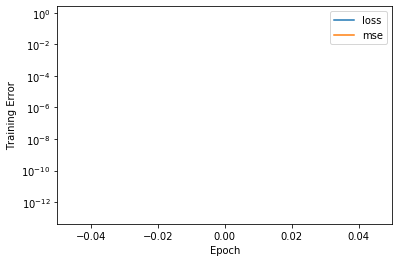

In [27]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['output_mse']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','mse'])

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [28]:
testdatagenerator = DataGenerator(test, rating_matrix)

results = model1.evaluate(testdatagenerator)

print(results)

12502/12502 [==============================] - 231s 18ms/step - loss: 0.6075 - decoder_loss: 0.2674 - decoder2_loss: 0.3385 - output_loss: 5.9193e-08 - decoder_accuracy: 0.8974 - decoder_MAPE: 79145624.0000 - decoder_mse: 0.0793 - decoder2_accuracy: 0.8683 - decoder2_MAPE: 101551824.0000 - decoder2_mse: 0.1015 - output_accuracy: 1.0000 - output_MAPE: 0.0000e+00 - output_mse: 0.0000e+00: 3:14 - loss: 0.6060 - decoder_loss: 0.2674 - decoder2_loss: 0.3369 - output_loss: 5.9188e-08 - decoder_accuracy: 0.8973 - decoder_MAPE: 79105544.0000 - decoder_mse: 0.0793 - decoder2_accuracy: 0.8691 - decoder2_MAPE: 101712 - ETA: 3:06 - loss: 0.6056 - decoder_loss: 0.2673 - decoder2_loss: 0.3366 - output_loss: 5.9188e-08 - decoder_accuracy: 0.8973 - decoder_MAPE: 79111288.0000 - decoder_mse: 0.0793 - decoder2_accuracy: 0.8692 - decoder2_MAPE: 101740104.0000 - decoder2_mse: 0.1008 - output_accuracy: 1.0000 - output_MAPE: 0.0000e - ETA: 3:04 - loss: 0.6060 - decoder_loss: 0.2675 - decoder2_loss: 0.3368 -

In [83]:
#y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_hat = model1.predict(testdatagenerator)

y_true = rating_matrix

In [84]:
print('y_hat:', y_hat)
print('y_true',y_true)

y_hat: [array([[0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083],
       [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083],
       [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083],
       ...,
       [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083],
       [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083],
       [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
        0.13790083]], dtype=float32), array([[0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
        0.26590684],
       [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
        0.26590684],
       [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
        0.26590684],
       ...,
       [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
        0.26590684],
       [0.0

In [92]:
tmp=y_hat[0]
print(tmp.shape)
print(tmp)

(200032, 3706)
[[0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]
 [0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]
 [0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]
 ...
 [0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]
 [0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]
 [0.57645136 0.2890096  0.19324008 ... 0.02768102 0.01395561 0.13790083]]


In [90]:
tmp=y_hat[1]
print(tmp.shape)
print(tmp)

(200032, 6040)
[[0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]
 [0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]
 [0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]
 ...
 [0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]
 [0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]
 [0.06025077 0.12852241 0.06877095 ... 0.02109479 0.08990169 0.26590684]]


In [109]:
tmp=y_hat[2]
print(tmp.shape)
print(tmp)

(200032, 1)
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [101]:
y_item=np.array(y_hat[0])
type(y_item)
y_user=np.array(y_hat[1])


In [102]:
y_user=y_user.transpose()

In [103]:
tmp=np.dot(y_user,y_item)

In [105]:
tmp.shape
print(tmp)

[[ 6947.428     3483.1394    2328.9495   ...   333.61612    168.19269
   1661.9797  ]
 [14819.689     7430.0767    4967.9873   ...   711.6368     358.7769
   3545.2012  ]
 [ 7929.8403    3975.7551    2658.2705   ...   380.79147    191.9778
   1896.9988  ]
 ...
 [ 2432.391     1219.5029     815.3961   ...   116.804016    58.887108
    581.89624 ]
 [10366.444     5197.313     3475.0522   ...   497.79608    250.96756
   2479.9253  ]
 [30661.238    15372.333    10278.336    ...  1472.3363     742.2898
   7334.9497  ]]


In [85]:
print(type(y_hat))
print(type(y_true))

y_true.shape

<class 'list'>
<class 'numpy.ndarray'>


(6040, 3706)

In [80]:
y_hat

[array([[0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083],
        [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083],
        [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083],
        ...,
        [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083],
        [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083],
        [0.57645136, 0.2890096 , 0.19324008, ..., 0.02768102, 0.01395561,
         0.13790083]], dtype=float32),
 array([[0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
         0.26590684],
        [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
         0.26590684],
        [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
         0.26590684],
        ...,
        [0.06025077, 0.12852241, 0.06877095, ..., 0.02109479, 0.08990169,
         0.26590684

In [75]:
type(temp)

list

In [70]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_true)

0.0

#References

Input layer:

- Embedding layer: [Link](https://gdcoder.com/-what-is-an-embedding-layer/)
- Embedding lookup: [link text](https://keras.io/layers/embeddings/)
- Multi input: [link text](https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models)
    